In [100]:

from concurrent.futures import ThreadPoolExecutor
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn import ensemble
from sklearn.svm import NuSVR, LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
import time
from numba import prange
import matplotlib.pyplot as plt
%matplotlib inline


In [101]:
MODELS = {DecisionTreeRegressor, ensemble.ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, NuSVR, ExtraTreeRegressor,
          LinearRegression, BayesianRidge, KNeighborsRegressor, XGBRegressor, XGBRFRegressor, MLPRegressor, LassoLarsIC,
          ElasticNet, SGDRegressor, LassoLars, Lasso, LinearSVR, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor}


In [102]:
housing = pd.read_csv(r'./datasets/kc_house_data.csv').sample(5000)
quality = pd.read_csv(r'./datasets/winequality-red.csv')


In [103]:
housing


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17106,3279000420,20150115T000000,233000.0,3,1.75,1460,7800,1.0,0,0,...,7,1040,420,1979,0,98023,47.3035,-122.382,1310,7865
4732,4141400100,20150120T000000,545000.0,4,2.25,2050,9720,2.0,0,0,...,8,2050,0,1967,0,98008,47.5911,-122.119,2310,9680
3690,6303401050,20150220T000000,132500.0,3,0.75,850,8573,1.0,0,0,...,6,600,250,1945,0,98146,47.5030,-122.356,850,8382
16591,3448900420,20140922T000000,620000.0,4,2.50,2500,8282,2.0,0,0,...,9,2500,0,2013,0,98056,47.5127,-122.169,2500,8046
622,9500900135,20141021T000000,200000.0,3,1.50,1210,10588,1.0,0,0,...,7,1210,0,1958,0,98002,47.2876,-122.212,1408,10588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4424,826069002,20141029T000000,355000.0,2,1.00,1350,368517,1.0,0,0,...,6,1350,0,1947,0,98077,47.7617,-122.061,2330,104108
16249,8925100440,20150323T000000,925000.0,4,2.25,2110,6375,1.0,0,2,...,8,1600,510,1941,0,98115,47.6819,-122.272,2760,6375
9407,5104510120,20150327T000000,305000.0,3,2.50,1690,5175,2.0,0,0,...,7,1690,0,2002,0,98038,47.3564,-122.016,1830,5175
14899,2125059163,20140703T000000,1042030.0,4,5.00,4110,43560,2.0,0,0,...,11,4110,0,1978,0,98005,47.6353,-122.180,3650,43995


In [104]:
quality


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [105]:
housing = housing.dropna()
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 17106 to 13844
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [106]:
quality.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [107]:
def metrics(tt, tp, vt, vp, model,
            time=None): return {
    "model": model,
    'time': time,
    "mse": (mean_squared_error(tt, tp),
            mean_squared_error(vt, vp)),
    'r2': (r2_score(tt, tp),
           r2_score(vt, vp))
}


def create_model(X, y, model_name,
                 time_it: bool = False):
    model = model_name()
    if time_it == True:
        begin = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        return (model, end - begin)
    return model.fit(X, y)


def get_metrics(model_name):
    Xt, Xv, yt, yv = train_test_split(
        housing_X, housing_y, train_size=.7)
    results = create_model(Xt, yt, model_name, time_it=True)
    model, time = results[0], results[1]
    return metrics(
        yt, model.predict(Xt), yv,
        model.predict(Xv), model_name, time)


def get_results(X, y, models):
    results = []
    with ThreadPoolExecutor(max_workers=len(models)) as executor:
        res = executor.map(get_metrics, models)
        results = [i for i in res if i]
    return results


def plot_results(results: 'list[dict]'):
    y = [i['model'] for i in results]
    pos = np.arange(len(y))
    plt.barh(pos, [i['mse'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Validation')
    plt.show()
    plt.barh(pos, [i['mse'][0] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('MSE Traning')
    plt.show()
    plt.barh(pos, [i['time'] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Time')
    plt.show()
    plt.barh(pos, [i['r2'][1] for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('R2')
    plt.show()
    plt.barh(pos, [i['time'] * i['mse'][1] * -
             1 for i in results], align='center',)
    plt.yticks(pos, y)
    plt.title('Efficiency (Higher the better)')
    plt.show()
    plt.barh(pos, [-1 * i['time'] * i['mse'][1] / (i['mse']
             [1] - i['mse'][0]) for i in results], align='center')
    plt.yticks(pos, y)
    plt.title('Weighted Efficiency (Higher the better)')
    plt.show()


In [108]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 17106 to 13844
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             5000 non-null   int64  
 1   date           5000 non-null   object 
 2   price          5000 non-null   float64
 3   bedrooms       5000 non-null   int64  
 4   bathrooms      5000 non-null   float64
 5   sqft_living    5000 non-null   int64  
 6   sqft_lot       5000 non-null   int64  
 7   floors         5000 non-null   float64
 8   waterfront     5000 non-null   int64  
 9   view           5000 non-null   int64  
 10  condition      5000 non-null   int64  
 11  grade          5000 non-null   int64  
 12  sqft_above     5000 non-null   int64  
 13  sqft_basement  5000 non-null   int64  
 14  yr_built       5000 non-null   int64  
 15  yr_renovated   5000 non-null   int64  
 16  zipcode        5000 non-null   int64  
 17  lat            5000 non-null   float64
 18  lon

In [109]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [110]:
housing_y


17106     233000.0
4732      545000.0
3690      132500.0
16591     620000.0
622       200000.0
           ...    
4424      355000.0
16249     925000.0
9407      305000.0
14899    1042030.0
13844     765000.0
Name: price, Length: 5000, dtype: float64

In [111]:
housing_X = MinMaxScaler().fit_transform(
    RobustScaler().fit_transform(housing_X))


In [112]:
housing_results = get_results(
    housing_X, housing_y, MODELS)


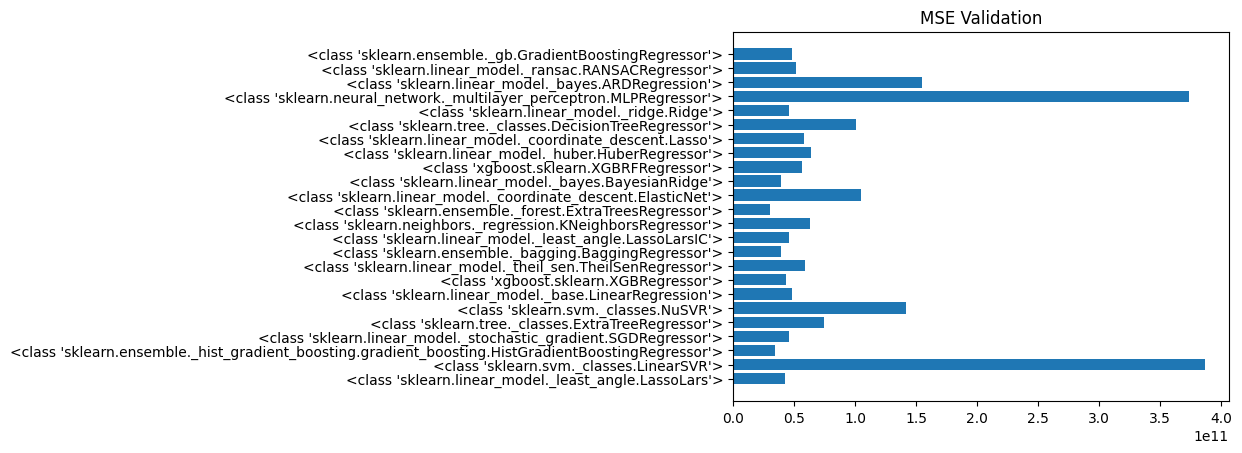

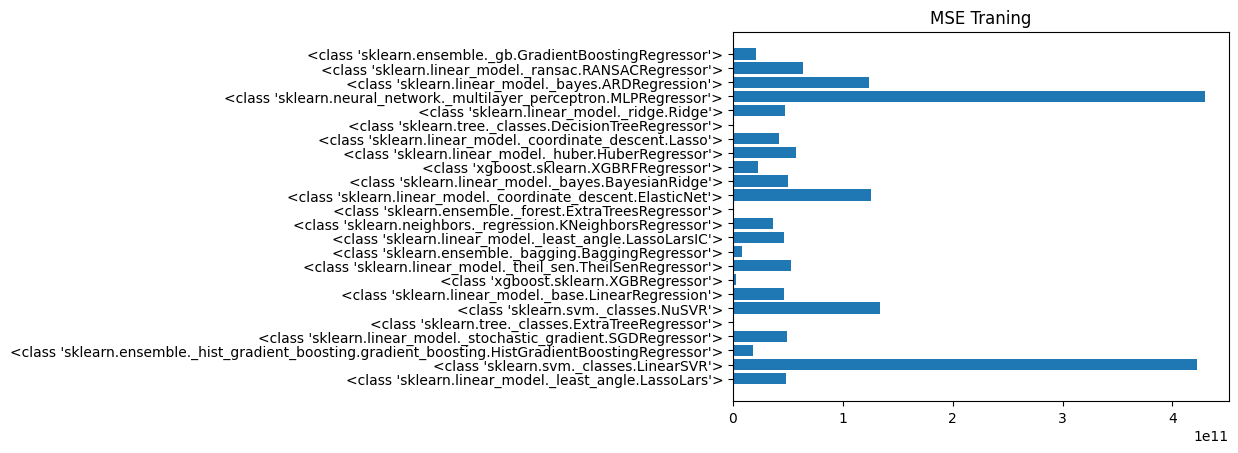

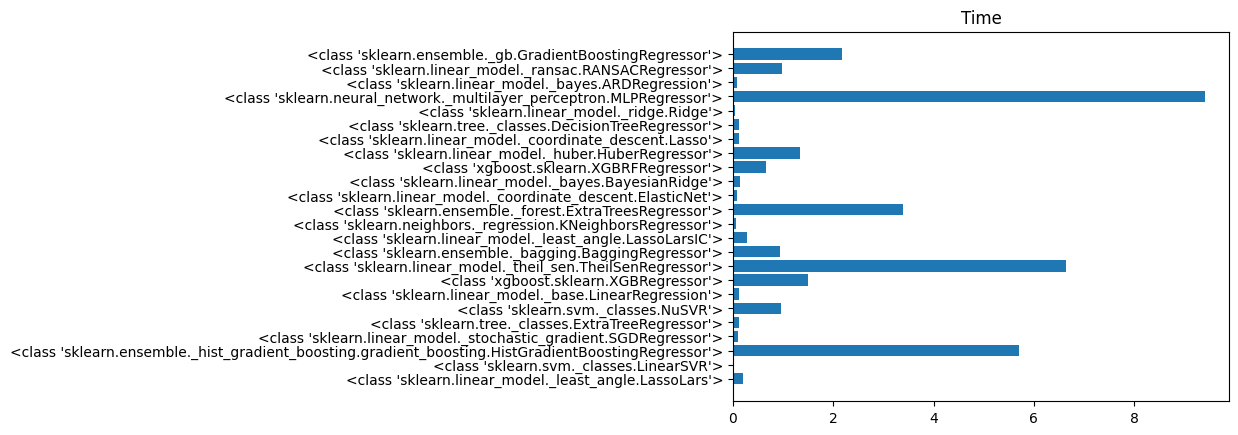

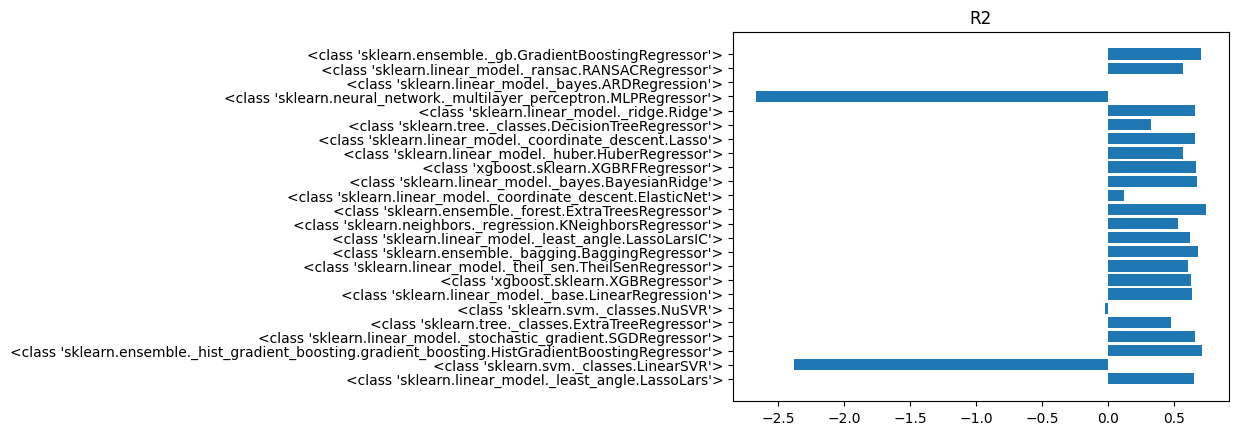

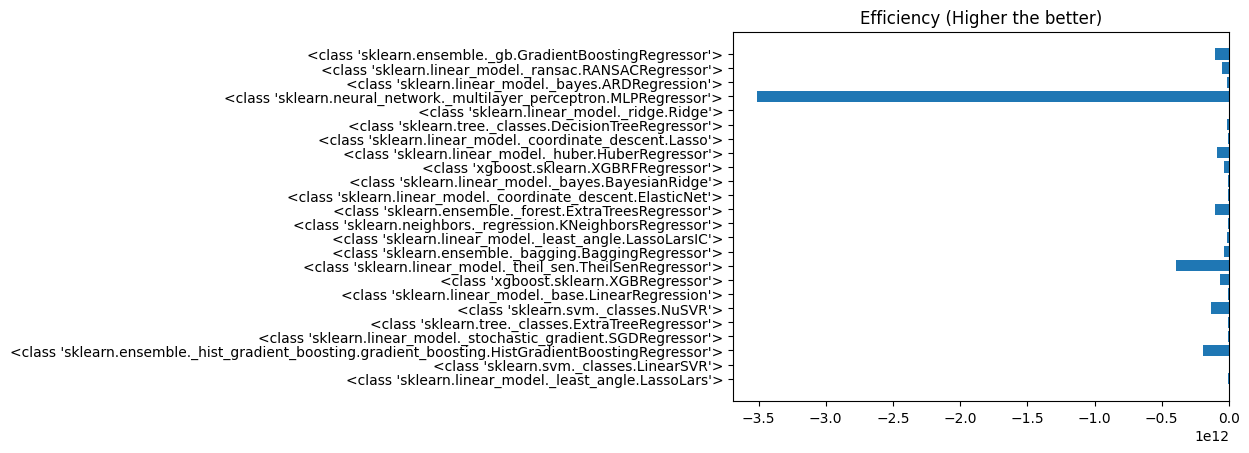

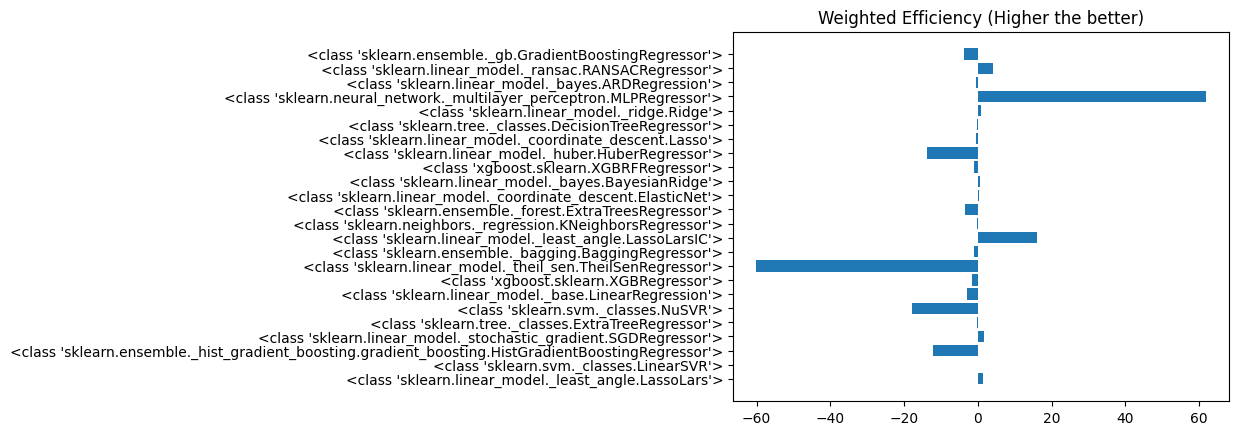

In [113]:
plot_results(housing_results)


In [114]:
X_train, X_val, y_train, y_val = train_test_split(quality_X, quality_y, stratify=quality_y, train_size=.7)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

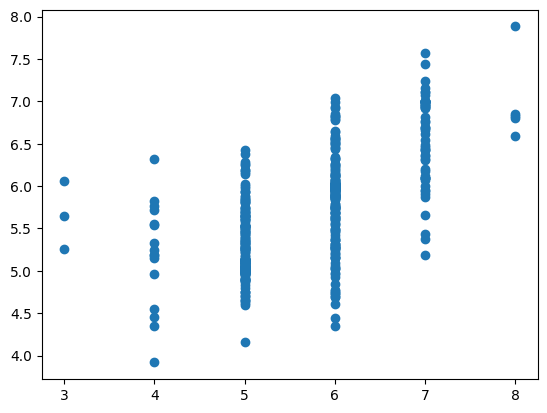

In [115]:
plt.scatter(y_val, preds);

In [116]:
mean_squared_error(y_val, preds), mean_squared_log_error(y_val, preds), mean_absolute_error(y_val, preds)

(0.38603475238341184, 0.009618713147085031, 0.4209789698322614)

In [117]:
mean_squared_error(y_train, xgb.predict(X_train)), mean_squared_log_error(y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train))

(0.0012942001480727129, 3.089466462176407e-05, 0.023410254019088677)

In [118]:
xgb.score(X_val, y_val)

0.4045696605915443

In [119]:
xgb.score(X_train, y_train)

0.9980187749994976

In [120]:
quality_X = quality.drop(['quality'], axis=1)
quality_y = quality['quality']
housing_X = housing\
    .drop(['id', 'date', 'zipcode',
           'lat', 'long', 'price'], axis=1)
housing_y = housing['price']


In [220]:
from numpy import full
from pandas import DataFrame, concat
from numba import prange
from concurrent.futures import ThreadPoolExecutor
# Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.svm import NuSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet, SGDRegressor, LassoLars, Lasso, Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from time import perf_counter
from copy import deepcopy


class VGBRegressor(object):
    """_summary_

    Args:
        object (_type_): _description_
    """
    def __init__(self):
        """ Initialize VGBRegressor Object
        """
        self._ensemble = []

    def _metrics(self, vt, vp, model, time=None):
        """_summary_

        Args:
            vt (_type_): _description_
            vp (_type_): _description_
            model (_type_): _description_
            time (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        if self.custom_loss_metrics:
            return {'model': model, 'time': time, 'loss': self.custom_loss_metrics(vt, vp)}
        return {"model": model, "time": time, "loss": mean_squared_error(vt, vp)}

    def _create_model(self, X, y, model_name, time_it: bool = False):
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_): _description_
            model_name (_type_): _description_
            time_it (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        model = model_name()
        if time_it:
            begin = perf_counter()
            model.fit(X, y)
            end = perf_counter()
            return (model, end - begin)
        return (model.fit(X, y), None)

    def _get_metrics(self, model_name):
        """_summary_

        Args:
            model_name (_type_): _description_

        Returns:
            _type_: _description_
        """
        try:
            Xt, Xv, yt, yv = train_test_split(self._X, self._y)
            results = self._create_model(Xt, yt, model_name, time_it=False)
            model, time = results[0], results[1]
            return self._metrics(yv,
                                 model.predict(Xv), model, time)
        except Exception:
            return None

    def _get_results(self, X, y) -> list:
        """_summary_

        Args:
            X (_type_): _description_
            y (_type_): _description_

        Returns:
            list: _description_
        """
        results = []
        self._X = KNNImputer(weights='distance').fit_transform(X)
        self._y = y
        with ThreadPoolExecutor(max_workers=len(self._models)) as executor:
            res = executor.map(self._get_metrics, self._models)
            results = [i for i in res if i]
        return results

    def fit(
        self, X_train, y_train,
        early_stopping: bool = False,
        early_stopping_min_delta: float = 0.001,
        early_stopping_patience: int = 10,
        custom_models: list = None,
        learning_rate: float = 0.05,
        n_estimators: int = 200,
        warm_start: bool = False,
        complexity: bool = False,
        custom_loss_metrics: object = False,
    ):
        """_summary_

        Args:
            X_train (_type_): _description_
            y_train (_type_): _description_
            early_stopping (bool, optional): _description_. Defaults to False.
            early_stopping_min_delta (float, optional): _description_. Defaults to 0.001.
            early_stopping_patience (int, optional): _description_. Defaults to 10.
            custom_models (list, optional): _description_. Defaults to None.
            learning_rate (float, optional): _description_. Defaults to 0.05.
            n_estimators (int, optional): _description_. Defaults to 100.
            warm_start (bool, optional): _description_. Defaults to False.
            complexity (bool, optional): _description_. Defaults to False.
            custom_loss_metrics (object, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if custom_models:
            self._models = custom_models
        self.custom_loss_metrics = custom_loss_metrics
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.early_stopping = early_stopping
        self.early_stopping_min_delta = early_stopping_min_delta
        self.early_stopping_patience = early_stopping_patience
        if custom_models:
            self._models = custom_models
        else:
            if complexity:
                self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor, HistGradientBoostingRegressor,
                                ElasticNet, LassoLars, Lasso, GradientBoostingRegressor, ExtraTreesRegressor,
                                BaggingRegressor, NuSVR, XGBRegressor, SGDRegressor, KernelRidge, MLPRegressor,
                                Ridge, ARDRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor, LassoLarsIC)
            else:
                self._models = (DecisionTreeRegressor, LinearRegression, BayesianRidge, KNeighborsRegressor,
                                ElasticNet, LassoLars, Lasso, SGDRegressor, BaggingRegressor, ExtraTreesRegressor,
                                Ridge, ARDRegression, RANSACRegressor, LassoLarsIC)
        X_train = deepcopy(X_train)
        self._y_mean = y_train.mean()
        # base model: mean
        # computer residuals: y - y hat
        # for n_estimators: a) y = prev residuals && residuals * learning rate
        # add early stopping
        # restore best weights
        # ada boost and adaptive scaling for learning rates

        preds = DataFrame(
            data={'yt': y_train, 'p0': full((len(y_train)), y_train - self._y_mean)})
        residuals = DataFrame(
            data={'r0': y_train - self._y_mean})
        errors = []
        if not early_stopping:
            if warm_start:
                for i in prange(1, self.n_estimators + 1):
                    y = residuals[f'r{i - 1}']
                    results = self._get_results(X_train, y)
                    min_loss = min(results, key=lambda x: x.get(
                        "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
                    min_model = [i['model']
                                 for i in results if min_loss >= i['loss']][0]
                    preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
                        X_train) * self.learning_rate
                    residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
                    if i % 3 == 0:
                        X_train[f"r{i}"] = residuals[f'r{i}'].copy()
                    try:
                        errors.append(mean_squared_error(
                            preds['yt'], preds[f'p{i}']))
                    except Exception:
                        df = concat(
                            [preds['yt'], preds[f'p{i - 1}']], axis=1).dropna()
                        errors.append(mean_squared_error(
                            df['yt'], df[f"p{i - 1}"]))
                    self._ensemble.append(min_model)
                    if residuals[f'r{i}'] == 0: break
                    if errors[i - 1] == 0:
                        break
            else:
                for i in prange(1, self.n_estimators + 1):
                    y = residuals[f'r{i - 1}']
                    results = self._get_results(X_train, y)
                    min_loss = min(results, key=lambda x: x.get(
                        "loss", float('inf')))["loss"]  # https://stackoverflow.com/a/19619294
                    min_model = [i['model']
                                 for i in results if min_loss >= i['loss']][0]
                    preds[f'p{i}'] = residuals.sum(axis=1) + min_model.predict(
                        X_train) * self.learning_rate
                    residuals[f'r{i}'] = preds['yt'] - preds[f'p{i}']
                    errors.append(mean_squared_error(
                        preds['yt'], preds[f'p{i}']))
                    self._ensemble.append(min_model)
                    if residuals[f'r{i}'] == 0: break
                    if errors[i - 1] == 0:
                        break
        else:
            return "TODO"
        min_error = min(errors)
        min_error_i = [i for i in prange(
            len(errors)) if errors[i] == min_error][0]
        self._ensemble, errors = self._ensemble[:
                                                min_error_i], errors[:min_error_i]
        residuals = residuals[:len(errors)]
        return self._ensemble, (residuals, errors)
    
    def predict(self, X_test):
        """_summary_

        Args:
            X_test (_type_): _description_

        Returns:
            _type_: _description_
        """
        try: val = self._ensemble[0]
        except Exception:
            return "Please train the model first"
        # X_test = self._robust.transform(self._minimax.transform(deepcopy(X_test)))
        preds = DataFrame(
            data={'p0': full((len(X_test)), self._y_mean)})
        for i in prange(len(self._ensemble)):
            preds[f"p{i}"] = self._ensemble[i].predict(X_test)
        preds_ = preds.sum(axis=1)
        return preds_
    
    def score(self, X_test, y_true):
        """
        Args:
            X_test (Iterable)
            y_true (Iterable)

        Returns:
            float: R2 Score for y_true and y_predicted
        """
        return r2_score(y_true, self.predict(X_test))

In [122]:
# from VGBoost import VGBRegressor

In [123]:
import warnings
warnings.filterwarnings("ignore")


In [124]:
model = VGBRegressor()

In [125]:
models = model.fit(X_train, y_train,)


In [126]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

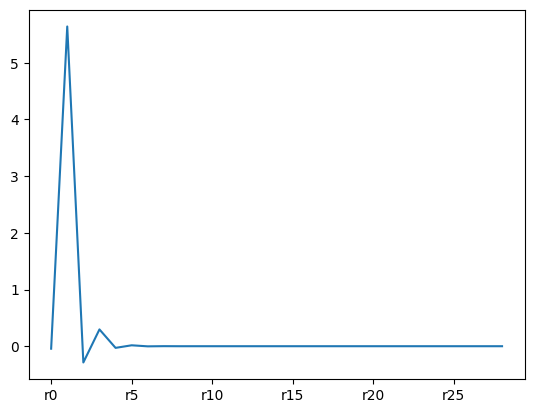

In [127]:
res.mean().plot()


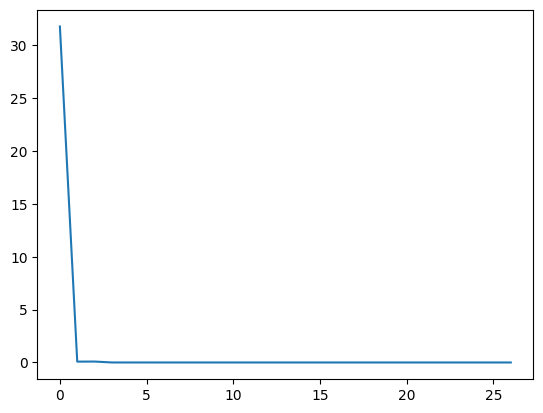

In [128]:
plt.plot(errors)


In [129]:
errors, models


([31.77291424318427,
  0.08028040824094987,
  0.08759069883145597,
  0.0008376334798858984,
  0.0002638662910964626,
  5.10293081333284e-06,
  8.55848696842429e-07,
  2.534396358216283e-08,
  2.939294565608326e-09,
  1.1385978199234818e-10,
  1.0525291341548057e-11,
  4.840479024729825e-13,
  3.880893190315703e-14,
  1.9924332504172314e-15,
  1.459702039496878e-16,
  8.042456464492998e-18,
  5.563465823827306e-19,
  3.207336474167506e-20,
  2.1389523999763865e-21,
  1.2694404946857793e-22,
  8.27010188054695e-24,
  5.000179590440308e-25,
  3.2095107479633765e-26,
  1.9584481840964817e-27,
  1.2282014418056952e-28,
  9.501579339203573e-30,
  7.759952112797397e-31],
 [BayesianRidge(),
  LinearRegression(),
  LinearRegression(),
  LinearRegression(),
  RANSACRegressor(),
  LinearRegression(),
  LinearRegression(),
  RANSACRegressor(),
  LinearRegression(),
  RANSACRegressor(),
  LinearRegression(),
  LinearRegression(),
  RANSACRegressor(),
  LinearRegression(),
  LinearRegression(),
  Li

In [130]:
/len errors


27

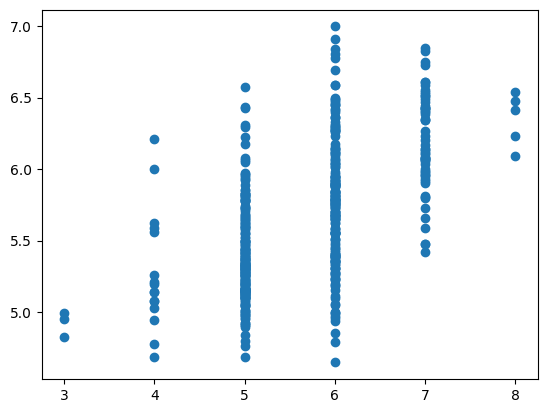

In [131]:
plt.scatter(y_val, model.predict(X_val))

In [132]:
model.score(X_val, y_val)

0.3502573780724403

In [133]:
model.score(X_train, y_train)

0.35412763598660013

In [134]:
mean_squared_error(y_val, model.predict(X_val)), mean_squared_log_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))

(0.42124697981957143, 0.009943870742868744, 0.5103687155087466)

In [135]:
mean_squared_error(y_train, model.predict(X_train)), mean_squared_log_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))

(0.421904684692694, 0.010008154009577034, 0.5047755513931931)

In [136]:
model = VGBRegressor()
models = model.fit(X_train, y_train, complexity=True,)


In [137]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

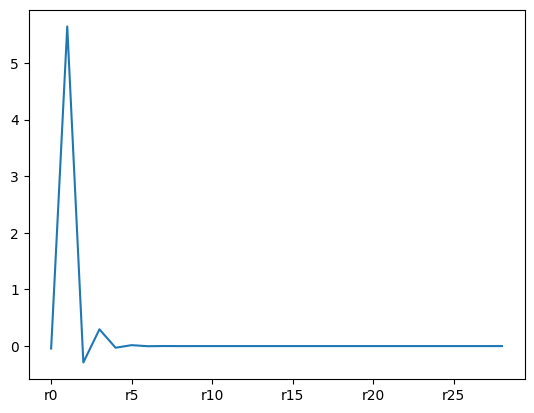

In [138]:
res.mean().plot()


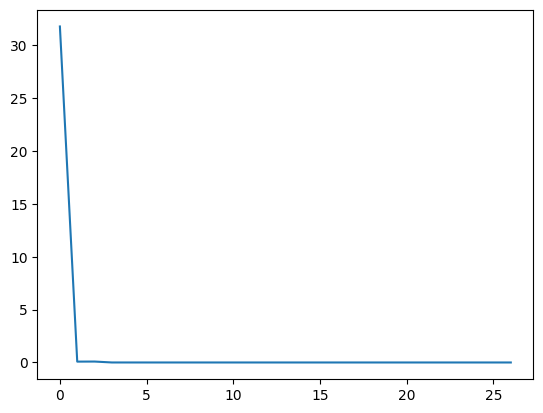

In [139]:
plt.plot(errors)


In [140]:
errors, models


([31.77921057130433,
  0.08107417904903466,
  0.0876267085111973,
  0.0008393863291957296,
  0.0002639669710668181,
  5.1083914624289636e-06,
  8.560941573980912e-07,
  2.53600850171838e-08,
  2.9405147229927073e-09,
  1.13905975694316e-10,
  1.0529385661890555e-11,
  4.842045931843545e-13,
  3.882966473483644e-14,
  1.9930288424680146e-15,
  1.4601310973299377e-16,
  8.04348284028026e-18,
  5.565124788583459e-19,
  3.20782459239774e-20,
  2.1391607962200177e-21,
  1.2695289346203193e-22,
  8.270583573185566e-24,
  5.000725344365178e-25,
  3.210027913611339e-26,
  1.9589020082320814e-27,
  1.2220752565810565e-28,
  9.343666164253164e-30,
  7.759952112797397e-31],
 [BaggingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradientBoostingRegressor(),
  HistGradi

In [141]:
/len errors


27

In [142]:
model.score(X_val, y_val)

0.3891302219872663

In [143]:
model.score(X_train, y_train)

0.7800336869762146

In [144]:
mean_squared_error(y_val, model.predict(X_val)), mean_squared_log_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))

(0.3960445880670665, 0.009589397705918457, 0.4609977037146636)

In [145]:
mean_squared_error(y_train, model.predict(X_train)), mean_squared_log_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))

(0.1436890988223011, 0.003223025469953478, 0.2474696859185092)

In [146]:
X_train, X_val, y_train, y_val = train_test_split(
    housing_X, housing_y,
    train_size=.7,
)

In [147]:
model = VGBRegressor()  # 19.6


In [148]:
models = model.fit(housing_X, housing_y,)


In [149]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

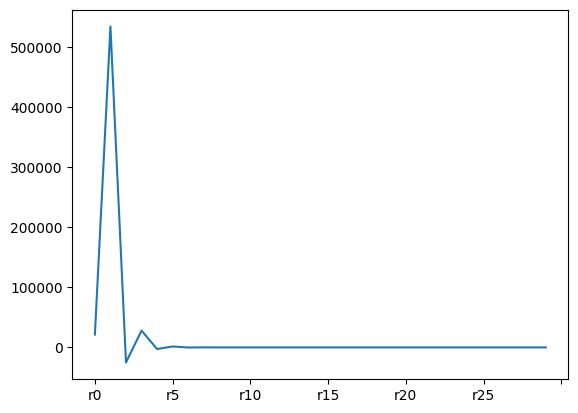

In [150]:
res.mean().plot()


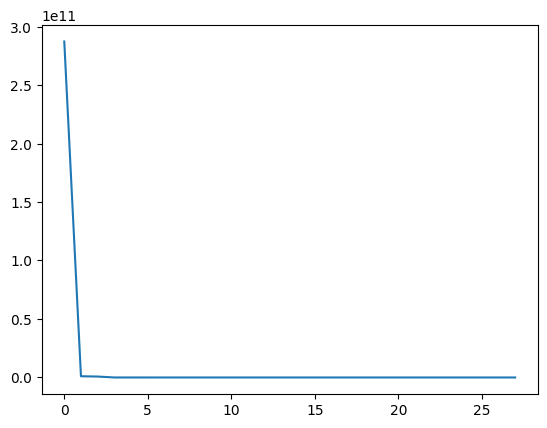

In [151]:
plt.plot(errors)


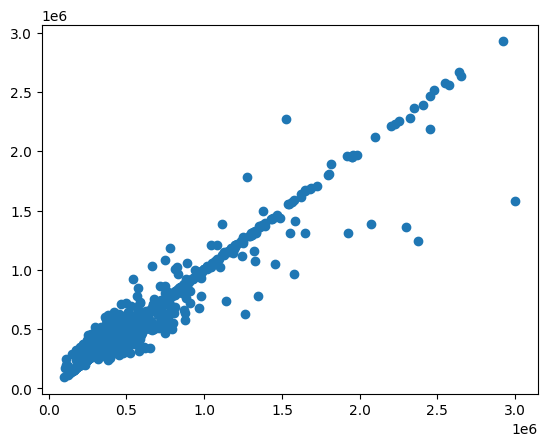

In [152]:
preds = model.predict(X_val)
plt.scatter(y_val, preds);

In [153]:
errors, models


([287223975922.642,
  1052315322.2206068,
  793414747.7476208,
  8475546.27391364,
  2397105.7133633895,
  48725.772656071495,
  7780.912605928677,
  236.95819149299328,
  26.786385830114664,
  1.0551810359496951,
  0.09611274693839755,
  0.004465671513567091,
  0.00035487614019672614,
  1.8334036801937455e-05,
  1.3361286649002686e-06,
  7.395208978683522e-08,
  5.096658617478513e-09,
  2.9474761003618e-10,
  1.960718077970754e-11,
  1.1664236343544388e-12,
  7.584294088733191e-14,
  4.59262050157971e-15,
  2.94360203394314e-16,
  1.8028835480863323e-17,
  1.1713951935044465e-18,
  6.934226752367858e-20,
  2.475707898234869e-21,
  6.136753702857406e-23],
 [ExtraTreesRegressor(),
  BaggingRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  LassoLarsIC(),
  ExtraTreesRegressor(),
  LinearRegression(),
  BaggingRegressor(),
  LinearRegression(),
  ExtraTreesRegressor(),
  Ridge(),
  BaggingRegressor(),
  LassoLarsIC(),
  BaggingRegressor(),
  Bayesia

In [154]:
/len errors


28

In [155]:
model.score(X_val, y_val), model.score(X_train, y_train)

(0.9345054364013727, 0.9324334669312376)

In [156]:
(
    mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))
), (
    mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))
)

((8478119442.956797, 31736.897460847144),
 (9102797874.459028, 33944.2061658684))

In [157]:
X_train, X_val, y_train, y_val = train_test_split(
    housing_X, housing_y,
    train_size=.7,
)
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)
model = xgb

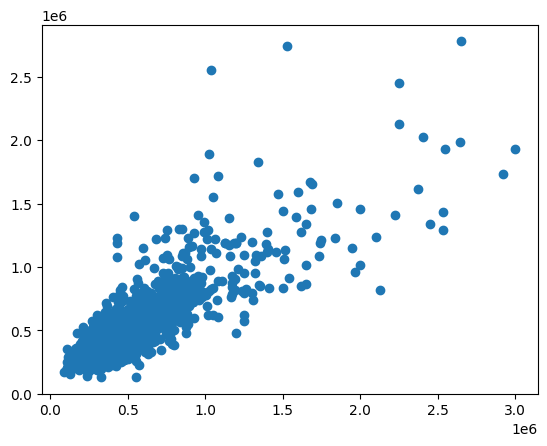

In [158]:
plt.scatter(y_val, preds);

In [159]:
(
    mean_squared_error(y_val, preds), mean_absolute_error(y_val, preds)
), (
    mean_squared_error(y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train))
)

((38440172665.14476, 127940.99963020833),
 (2969034426.6592526, 39990.11971651786))

In [160]:
(56298665461.59785 - 16488302073.342546)/56298665461.59785

0.707128012038057

In [161]:
model.score(X_val, y_val), model.score(X_train, y_train)

(0.6772252732832191, 0.9786834156779263)

In [162]:
model = VGBRegressor()  # 19.6


In [163]:
models = model.fit(housing_X, housing_y, complexity=True)


In [164]:
models, res, errors = models[0], models[1][0], models[1][1]


<AxesSubplot: >

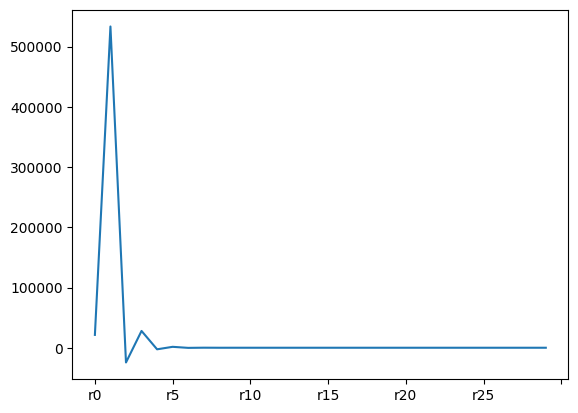

In [165]:
res.mean().plot()


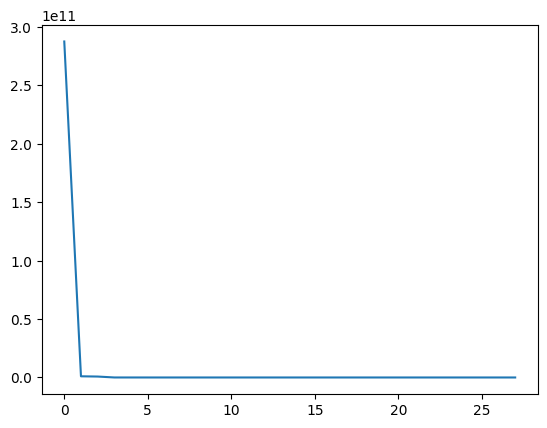

In [166]:
plt.plot(errors)


In [167]:
errors, models


([287310622832.9563,
  1010030765.4685426,
  793714816.0256798,
  8402387.762935145,
  2398471.9951817323,
  48734.41743750446,
  7807.221475920897,
  237.92974635179615,
  26.883111504692188,
  1.0579161971695696,
  0.09648509937413681,
  0.004481411863649067,
  0.00035639163074109527,
  1.8403637125543824e-05,
  1.3410528179023205e-06,
  7.419006955386846e-08,
  5.115239831807057e-09,
  2.9556268430785577e-10,
  1.9674664537276677e-11,
  1.1694672603403375e-12,
  7.611069707626532e-14,
  4.605022782260901e-15,
  2.952748867878348e-16,
  1.8080740474024942e-17,
  1.1748415588085873e-18,
  6.937492064379523e-20,
  2.3409026046793473e-21,
  4.6798570335800094e-23],
 [BaggingRegressor(),
  GradientBoostingRegressor(),
  ExtraTreesRegressor(),
  HistGradientBoostingRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1

In [168]:
/len errors


28

In [169]:
model.score(X_val, y_val), model.score(X_train, y_train)

(0.884672686799456, 0.8940026002177993)

In [170]:
(
    mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))
), (
    mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))
)

((13734662182.290562, 66827.64684701341),
 (14763618989.550282, 66466.41333805012))

In [171]:
(16488302073.342546 - 11046591583.660015) / 11046591583.660015 * 100

49.26144366314623

#Benchmarks

In [172]:
from sklearn.datasets import fetch_california_housing, make_friedman1, make_friedman2, make_friedman3

In [181]:
fch = fetch_california_housing(as_frame=True)['data']

In [183]:
X, y = fch.drop(['MedInc'], axis=1), fch['MedInc']

In [203]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=.7)

In [200]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_val)

In [201]:
((mean_squared_error(y_val, preds), mean_absolute_error(y_val, preds)), (mean_squared_error(y_train, xgb.predict(X_train)), mean_absolute_error(y_train, xgb.predict(X_train))))

((0.9140554770655424, 0.6621871073663569),
 (0.0235786095744912, 0.10923823698375576))

In [202]:
(xgb.score(X_val, y_val), xgb.score(X_train, y_train))

(0.7436114909006987, 0.9941086777880419)

##VGBoost

In [217]:
model = VGBRegressor()
model.fit(X_train, y_train,)

([ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  ExtraTreesRegressor(),
  LinearRegression(),
  Ridge(),
  RANSACRegressor(),
  RANSACRegressor(),
  RANSACRegressor(),
  LinearRegression(),
  BayesianRidge(),
  BayesianRidge(),
  BayesianRidge(),
  BayesianRidge(),
  BayesianRidge(),
  LinearRegression(),
  LinearRegression(),
  BayesianRidge(),
  Ridge(),
  Ridge()],
 (             r0        r1        r2        r3        r4        r5        r6  \
  12066  1.592621  3.806548 -0.110696  0.195862 -0.015328  0.010267 -0.000987   
  3896   0.626321  3.857781 -0.164299  0.200847 -0.018192  0.010949 -0.001454   
  7432   0.157921  3.933713 -0.244219  0.208596 -0.022340  0.011547 -0.001694   
  14469  7.066721  3.532843  0.176694  0.173095 -0.0

In [218]:
(model.score(X_val, y_val), model.score(X_train, y_train))

(0.7967689461286777, 0.9495175294563437)

In [219]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))

((0.7011788243339908, 0.583523711848034),
 (0.18559886147944973, 0.159000982336241))

In [ ]:
model = VGBRegressor()
model.fit(X_train, y_train, complexity=True)

In [ ]:
(model.score(X_val, y_val), model.score(X_train, y_train))

In [ ]:
((mean_squared_error(y_val, model.predict(X_val)), mean_absolute_error(y_val, model.predict(X_val))),
 (mean_squared_error(y_train, model.predict(X_train)), mean_absolute_error(y_train, model.predict(X_train))))